In [14]:
import numpy as np

from sklearn.datasets import fetch_20newsgroups
from sklearn.datasets import fetch_mldata
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

from sklearn.feature_extraction.text import TfidfVectorizer

from matplotlib import pyplot as plt

In [5]:
def runLR(xtrain, ytrain, xtest, ytest):
    lr = LogisticRegression()
    lr.fit(xtrain, ytrain)
    print('Accuracy: ', lr.score(xtest, ytest))
    return lr

In [6]:
def runDTC(xtrain, ytrain, xtest, ytest, names=None, f=30):
    dt = DecisionTreeClassifier()
    dt.fit(xtrain, ytrain)
    print('Accuracy: ', dt.score(xtest, ytest))
    print('Top {} features using DTC'.format(f))
    if names is not None:
        if type(names) is list:
            print([names[z] for z in np.argsort(dt.feature_importances_)[::-1][:f]])
        else:
            print(names[np.argsort(dt.feature_importances_)[::-1][:f]])
    else:
        print([np.argsort(dt.feature_importances_)[::-1][:f]])
    return dt

# 20 News Groups

In [7]:
ngtrain = fetch_20newsgroups(subset='train', data_home='../Data')
ngtest = fetch_20newsgroups(subset='test', data_home='../Data')

In [8]:
ngtrain_vectorizer = TfidfVectorizer(stop_words='english', strip_accents='ascii')
_ngtrain_vectors = ngtrain_vectorizer.fit_transform(ngtrain.data)
ngtest_vectorizer = TfidfVectorizer(stop_words='english', strip_accents='ascii')
_ngtest_vectors = ngtest_vectorizer.fit_transform(ngtest.data)

In [9]:
# remove features in test that are not found in train
get_indices = lambda x, y: list(set(np.searchsorted(x, y)))
common_features = np.intersect1d(ngtrain_vectorizer.get_feature_names(), ngtest_vectorizer.get_feature_names())
ngtrain_vectors = _ngtrain_vectors[:, get_indices(ngtrain_vectorizer.get_feature_names(), common_features)]
ngtest_vectors = _ngtest_vectors[:, get_indices(ngtest_vectorizer.get_feature_names(), common_features)]

## Logistic Regression

In [10]:
nglr = runLR(ngtrain_vectors, ngtrain.target, ngtest_vectors, ngtest.target)

Accuracy:  0.8275358470525757


LogisticRegression of sklearn package uses the one-vs-rest model for a multi-class classification. Because of this, we get 20 (no. of classes in data) different sets of coefficients. Now in order to pick the best 30 features, I have chosen to pick the top 30 from each class instead of choosing the top 30 over all the classes. 

Since we are using the one-vs-rest model, to predict the output probability for each class, we can choose the most important features (30 in this eg) and use them to classify. 

In [11]:
f = 30
best_features = {}
for i in range(nglr.coef_.shape[0]):
    print('Top {} features for class `{}`:'.format(f, ngtrain.target_names[i]))
    _features = common_features[np.argsort(nglr.coef_[i])[::-1][:f]]
    best_features.update({ngtrain.target_names[i]: _features})
    print(_features)
    print('--'*15)

Top 30 features for class `alt.atheism`:
['keith' 'atheism' 'atheists' 'islamic' 'caltech' 'okcforum' 'god' 'islam'
 'mathew' 'jaeger' 'livesey' 'rushdie' 'mangoe' 'benedikt' 'umd'
 'religion' 'osrhe' 'wingate' 'edu' 'kmr4' 'sgi' 'bible' 'cobb' 'mantis'
 'gregg' 'tek' 'solntze' 'atheist' 'bobby' 'ico']
------------------------------
Top 30 features for class `comp.graphics`:
['graphics' 'image' '3d' 'polygon' 'tiff' 'images' 'files' 'pov' '3do'
 'format' 'points' 'animation' 'package' 'gif' 'vga' 'sphere' 'color'
 'vesa' 'surface' 'algorithm' 'program' 'file' '42' 'looking' 'library'
 'code' 'software' 'quicktime' 'xv' 'mpeg']
------------------------------
Top 30 features for class `comp.os.ms-windows.misc`:
['windows' 'file' 'ax' 'driver' 'drivers' 'files' 'cica' 'dos' 'win' 'nt'
 'risc' 'ini' 'mouse' 'ms' 'win3' 'fonts' 'font' 'ftp' 'printer' 'access'
 'microsoft' 'using' 'bmp' 'tw' 'program' 'card' 'manager' 'diamond'
 'norton' 'deskjet']
------------------------------
Top 30 featu

## Decision Tree Classifier

In [42]:
ngdt = runDTC(ngtrain_vectors, ngtrain.target, ngtest_vectors, ngtest.target, common_features)

Accuracy:  0.57063197026
Top 30 features using DTC
['clipper' 'dod' 'sale' 'windows' 'hockey' 'god' 'space' 'israel' 'car'
 'gun' 'baseball' 'turkish' 'bike' 'mac' 'graphics' 'window' 'nhl'
 'rutgers' 'geb' 'atheists' 'encryption' 'motif' 'article' 'orbit'
 'controller' 'team' 'nntp' 'com' 'edu' 'apple']


# MNIST

In [16]:
mnist = fetch_mldata('MNIST original', data_home='../Data')
mxtrain, mxtest, mytrain, mytest = train_test_split(mnist.data, mnist.target, test_size=0.33, random_state=42)

## Logistic Regression

In [20]:
# C=0.1, tol=0.1
mnlr = LogisticRegression(multi_class='multinomial', C=0.1, tol=0.1, solver='saga')
mnlr.fit(mxtrain, mytrain)
print('Accuracy: ', mnlr.score(mxtest, mytest))
# mnlr = runLR(mxtrain, mytrain, mxtest, mytest)

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=1, penalty='l2', random_state=None, solver='saga',
          tol=0.1, verbose=0, warm_start=False)

Accuracy:  0.9224675324675324


In [21]:
mnlr.coef_.shape

(10, 784)

In [22]:
f = 30
_indices = []
for i in range(mnlr.coef_.shape[0]):
    print('Top {} features for class `{}`:'.format(f, np.unique(mnist.target)[i]))
    _indices.append(np.argsort(mnlr.coef_[i])[::-1][:f])
    print(np.argsort(mnlr.coef_[i])[::-1][:f])
    print('--'*15)

Top 30 features for class `0.0`:
[240 303 360 486 514 275 571 331 399 387 599 416 359 572 181 388 513 481
 271 453 455 629 443 655 542 454 482 415 247 401]
------------------------------
Top 30 features for class `1.0`:
[350 378 322 323 406 434 351 295 462 379 621 294 433 489 490 407 622 267
 461 405 377 518 606 296 649 349 293 608 580 579]
------------------------------
Top 30 features for class `2.0`:
[501 528 473 445 500 444 529 527  97 454 567 388 584 556 607  98 611 461
 417 570 508 474 487  96 555 554 460 557 121 482]
------------------------------
Top 30 features for class `3.0`:
[712 710 709 123 711 708 377 713 122 537  96 525 536 267 679 128 124 563
 509 707 508 173 520 256 268 271 592 350 564 526]
------------------------------
Top 30 features for class `4.0`:
[348 375 376 463 490 347 320 436 409 464 411 403 427 437 399 318 317 374
 518 344 219 517 491 428 191 352 370 397 381 324]
------------------------------
Top 30 features for class `5.0`:
[304 305 276 248 277 220 303 249

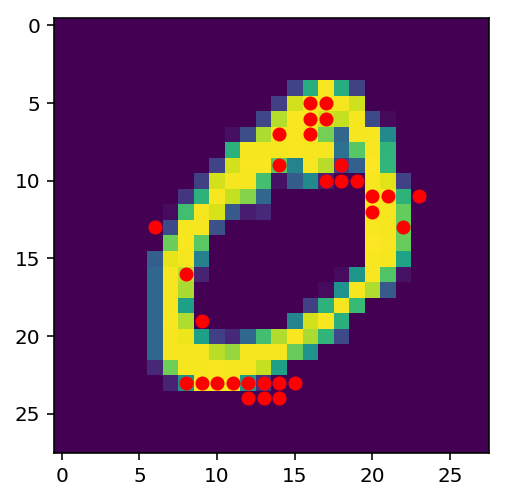

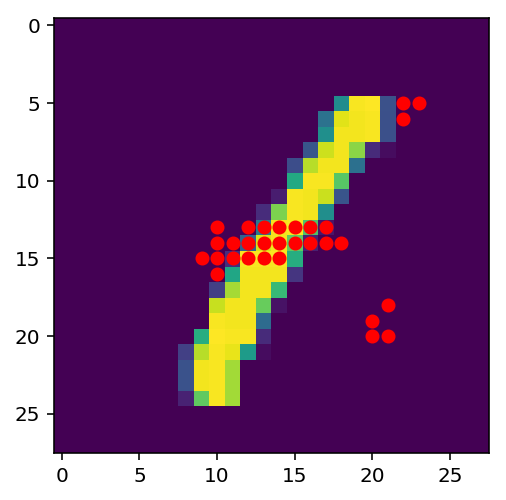

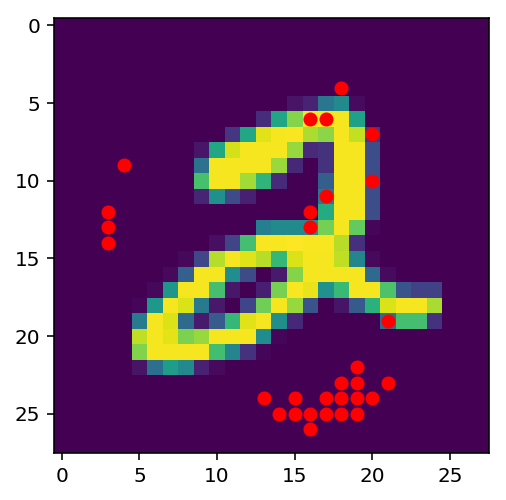

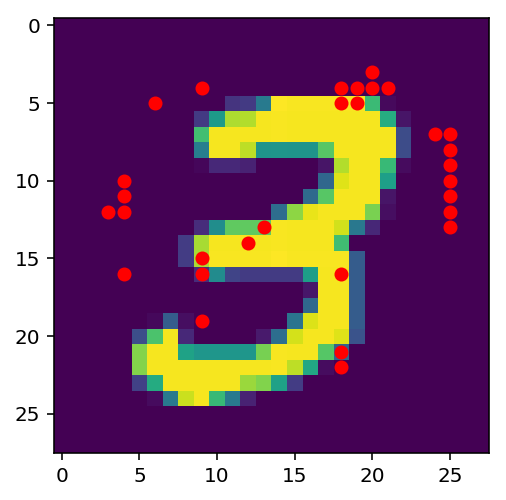

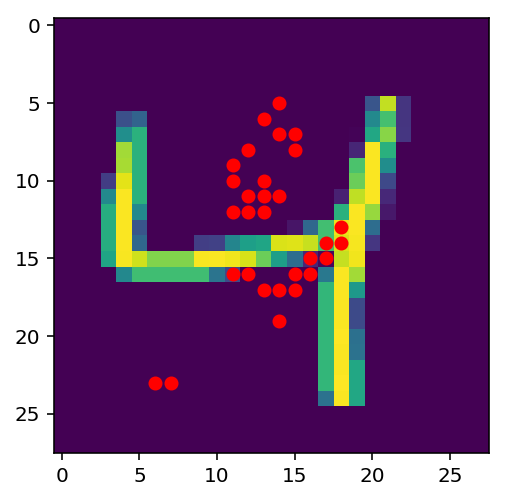

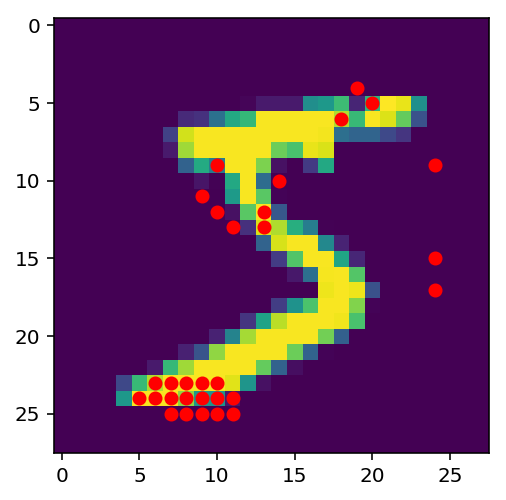

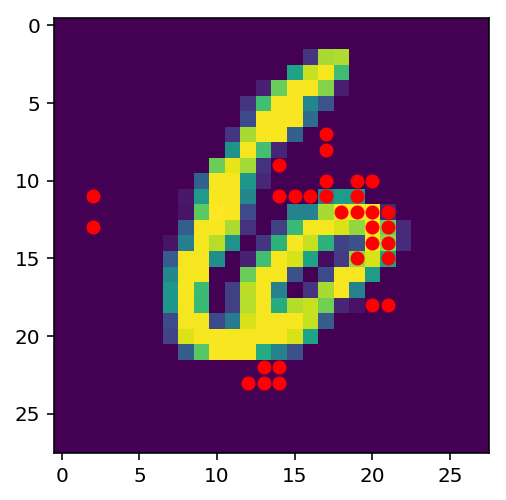

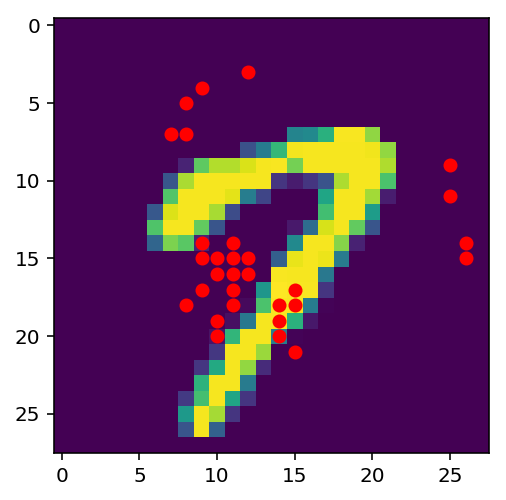

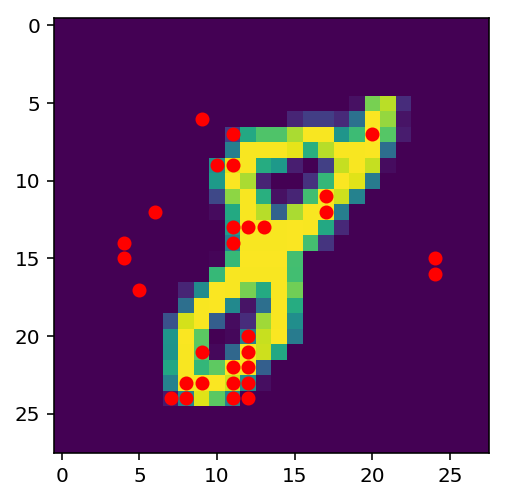

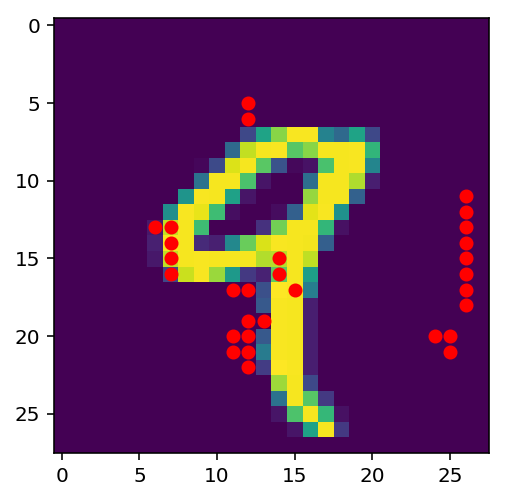

In [23]:
# _indices = np.array([
#     [224, 503, 614,  44,  89,  45, 226,  69, 676, 109, 668, 311,  87, 143, 172, 641, 118,  71,
#  339, 586, 201, 639,  59, 717, 360, 711, 694, 591, 257, 370],
#     [641, 359, 307, 312, 256, 472, 697, 693, 418, 416, 281, 395, 586, 670, 583, 174, 143,  67,
#  396, 453, 114, 276, 342, 120, 531, 203, 258, 535, 446, 698],
#     [503, 391, 706, 137, 478, 505, 367, 198, 277, 423, 696,  80, 418, 340, 221,  79, 422,  34,
#   33, 333, 165, 614, 390, 396, 143, 474, 313, 585, 562,  14],
#     [702, 197,  89, 446, 361, 449, 393, 586, 421, 450, 561, 646, 136, 668, 675, 695, 387, 670,
#  108, 590, 104, 338, 367, 451, 722, 395, 472, 705, 748, 676],
#     [478, 422, 393, 697, 475, 337,  90, 642, 281, 670, 446, 558, 723, 751, 109, 227, 583, 254,
#  117, 613, 360, 311, 136, 556, 417, 107, 669, 119, 105,  68],
#     [ 88, 390, 394, 361, 362, 392, 724, 734,  91, 416, 332, 641, 170, 422, 587, 143, 198, 304,
#  333, 618, 749, 675, 395, 478, 704, 279, 339, 424, 556, 306],
#     [195, 167, 139, 110,  81, 171,  79, 614,  47,  35,  87,  40, 642, 108, 452,  38,  48, 142,
#  117, 692, 311, 564,  77, 450,  91, 199, 586,  49, 201,  64],
#     [778, 282, 225, 773, 530, 533, 366, 446, 365, 666, 775, 556, 197, 133, 703, 612, 750, 536,
#  592, 722, 309, 423, 339, 171, 388, 764, 255, 448, 675, 120],
#     [451, 619, 363, 114, 417, 734, 750, 424, 395, 335, 107,  74, 704, 284, 736, 669, 118, 471,
#  500, 307, 390, 332, 563,  94, 255, 339, 251, 397, 278, 479],
#     [702, 119, 725, 504, 752, 777, 478, 334, 732, 446, 620, 774, 751, 612, 585, 666, 562, 228,
#  305, 640, 255, 695, 526, 721, 310, 283, 734, 676, 667, 677],
# ])

for i in range(len(_indices)):
    x = [int(val/28) for val in _indices[i]]
    y = [val%28 for val in _indices[i]]
    img = mnist.data[np.where(mnist.target==i)[0][0]]
    plt.imshow(img.reshape(28, 28))
    plt.plot(x, y, 'ro')
    plt.show()

## Decision Tree

In [45]:
mndtc = runDTC(mxtrain, mytrain, mxtest, mytest)

Accuracy:  0.868354978355
Top 30 features using DTC
[array([489, 350, 435, 347, 542, 211, 432, 270, 597, 486, 155, 354, 273,
       550, 296, 290, 405, 656, 657, 352, 297, 596, 458, 658, 301, 380,
       234, 404, 598, 515])]


# Spambase dataset

In [46]:
def spambasedata():
    f = open('../Data/spambase.data')
    target = []
    spam_data = []    
    for line in f.readlines():
        target.append(int(line[-2]))
        line = line[:-3].strip().split(',')
        spam_data.append(list(map(float, line)))
    target = np.array(target)
    f.close()
    f = open('../Data/spambase.names')
    names = []
    for line in f.readlines()[33:]:
        names.append(line.strip().split(':')[0])
    f.close()
    return spam_data, target, names

sdata, starget, snames = spambasedata()

In [47]:
sxtrain, sxtest, sytrain, sytest = train_test_split(sdata, starget, test_size=0.33, random_state=42)

## Logistic Regression

In [48]:
slr = runLR(sxtrain, sytrain, sxtest, sytest)

Accuracy:  0.930875576037


In [67]:
f = 30
print('Top {} features:'.format(f))
print([snames[j] for j in np.argsort(slr.coef_[0])[::-1][:f]])

Top 30 features:
['char_freq_$', 'word_freq_000', 'word_freq_remove', 'word_freq_addresses', 'word_freq_order', 'char_freq_#', 'word_freq_free', 'word_freq_business', 'word_freq_technology', 'word_freq_credit', 'word_freq_3d', 'word_freq_our', 'word_freq_over', 'word_freq_internet', 'word_freq_650', 'word_freq_money', 'word_freq_your', 'word_freq_font', 'char_freq_!', 'word_freq_report', 'word_freq_415', 'word_freq_all', 'word_freq_you', 'word_freq_email', 'word_freq_mail', 'word_freq_people', 'capital_run_length_longest', 'capital_run_length_total', 'capital_run_length_average', 'word_freq_telnet']


## Decision Tree classifier

In [60]:
sdt = runDTC(sxtrain, sytrain, sxtest, sytest, snames)

Accuracy:  0.909809084924
Top 30 features using DTC
['char_freq_$', 'word_freq_remove', 'char_freq_!', 'word_freq_hp', 'capital_run_length_average', 'word_freq_free', 'capital_run_length_longest', 'word_freq_our', 'word_freq_you', 'word_freq_edu', 'word_freq_your', 'word_freq_george', 'word_freq_will', 'word_freq_internet', 'word_freq_85', 'word_freq_technology', 'word_freq_all', 'word_freq_order', 'word_freq_re', 'word_freq_business', 'word_freq_pm', 'capital_run_length_total', 'word_freq_hpl', 'char_freq_;', 'word_freq_money', 'char_freq_#', 'word_freq_make', 'char_freq_(', 'word_freq_receive', 'word_freq_mail']
